## Example 2: Perturb File 3

Perform a perturbation on a file 3 section and create a new ENDF tape.  Adapted from Wim's `perty` C++ application.  This approach could be used in sensitivity analysis.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import ENDFtk
import patch

Define a pure Python perturbation function to be used here.

In [2]:
def perturb(x_in, y_in, start, stop, mult):

    # initialize output
    x_out = x_in
    y_out = y_in

    # add point if needed to start, stop
    target = (start, stop)
    idx = [0, 0]
    for i in range(2):
        idx[i] = np.searchsorted(x_out, target[i])
        if idx[i] < len(x_out) and \
                x_out[idx[i]] != target[i] and \
                target[i] > x_out[0] and \
                target[i] < x_out[-1]:

            interp = y_out[idx[i]-1] + ( (target[i]-x_out[idx[i]-1]) *
                                         (y_out[idx[i]]-y_out[idx[i]-1]) /
                                         (x_out[idx[i]]-x_out[idx[i]-1]) )

            x_out = np.insert(x_out, idx[i], target[i])
            y_out = np.insert(y_out, idx[i], interp)

    # modify values
    y_out[idx[0]:idx[1]] *= mult

    # return
    return x_out, y_out

As in Example 1, load in reconstructed U-235 tape and parse.

In [3]:
with open('tape22', 'r') as f:
    tape = ENDFtk.Tape(f.read())
initial = tape.materials[0].MF(3).MT(18).parse(3)

Perturb cross sections.  The perturbations used here are absurd, but that makes visualization easier!

In [5]:
energies = np.array(initial.energies)
cross_sections = np.array(initial.crossSections)
energies, cross_sections = perturb(energies, cross_sections,
                                   0.0, 0.1, 2)
energies, cross_sections = perturb(energies, cross_sections,
                                   1.0e4, 1.0e5, 2)
energies, cross_sections = perturb(energies, cross_sections,
                                   1.0e6, 1.0e10, 0.5)

Create a new section using the perturbed cross sections but maintaining the other parameters.

In [6]:
perturbed = ENDFtk.Type(initial.MT, initial.ZA, initial.AWR,
                        initial.QM, initial.QI, initial.LR,
                        [len(energies)], [2],
                        energies,
                        cross_sections)

Visualize these changes.  Resonance range is same in both cases, perturbations seen at thermal energies, in the URR, and at high energies -- as expected.

Text(0.5, 1.0, 'U-235 Fission Perturbation')

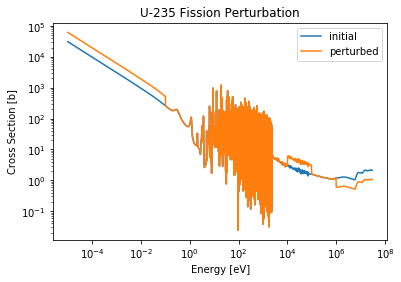

In [7]:
# plot the data
plt.plot(initial.energies, initial.crossSections, label='initial')
plt.plot(perturbed.energies, perturbed.crossSections, label='perturbed')

# adjust appearance of plot
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Energy [eV]')
plt.ylabel('Cross Section [b]')
plt.legend(loc=1)
plt.title('U-235 Fission Perturbation')

Create new ENDF tape including this perturbation.

In [8]:
# new File 3
file3_orig = tape.materials[0].MF(3).parse()
sections = file3_orig.sections
for i, section in enumerate(sections):
    if section.MT == 18:
        break
sections[i] = perturbed
file3 = ENDFtk.File3(sections)

In [9]:
# write new ENDF tape
with open('result.txt', 'w') as result:
    result.write(ENDFtk.TPID("perturbed U-235 RENDF", 1).to_string())
    for file in tape.materials[0].files:
        if file.fileNumber != 3:
            result.write(file.buffer)
        else:
            result.write(file3.to_string(9228))
    result.write(ENDFtk.MEND().to_string())
    result.write(ENDFtk.TEND().to_string())